# RNN com LSTM

In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations, chain

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

import models
import metrics

## Carregando os dados

In [140]:
us_change = pd.read_csv('us_change.csv')

In [141]:
# Convert the 'Quarter' column to datetime format using quarter ending
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = int(quarter[1]) * 3
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)
us_change['QuarterDummy'] = us_change['Quarter'].dt.quarter

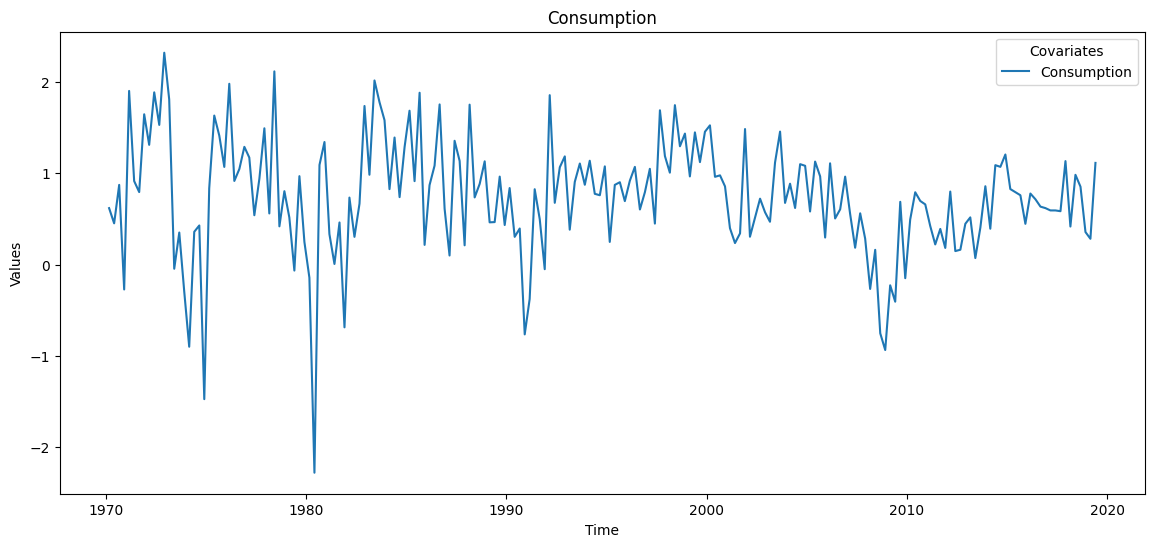

In [142]:
# Plot all covariates as time series

plt.figure(figsize=(14, 6))
sns.lineplot(data=us_change, x='Quarter', y='Consumption', label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

## Funções auxiliares

In [143]:
# Dataset functions

def create_dataset(df: pd.DataFrame, window_size: int, X_columns: list, y_column: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Create the dataset with the specified window size
    """
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:(i + window_size)][X_columns])
        y.append(df.iloc[i + window_size][y_column])
    return np.array(X), np.array(y)

def split_dataset(X: np.ndarray, y: np.ndarray, test_size: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split the dataset into training and testing sets
    """
    train_size = X.shape[0] - test_size
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [144]:
# Plot functions

def plot_lstm_loss(model: models.LSTM) -> None:
    """
    Plot the loss of the LSTM model
    """
    plt.figure(figsize=(14, 6))
    plt.plot(model.model.history.history['loss'], label='Training Loss')
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_resid(resid: np.ndarray) -> None:
    """
    Plot the residuals
    """
    plt.figure(figsize=(14, 6))
    plt.stem(resid)
    plt.title('Residuals')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

In [145]:
# Model functions

def get_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_train: np.ndarray, n_params) -> dict[str, float]:
    """
    Get the metrics for the model
    """
    return {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'R2': metrics.r2(y_true, y_pred),
        'MASE': metrics.mase(y_true, y_pred, y_train),
        'AIC': metrics.aic(y_true, y_pred, n_params),
        'BIC': metrics.bic(y_true, y_pred, n_params),
    }

## LSTM na própria série temporal

Nesse primeiro caso vamos utilizar a própria série temporal para prever o próximo valor.

### Apresentando o funcionamento

In [146]:
# Gerando dataset com janela de 5 observações
X, y = create_dataset(us_change, 5, ['Consumption'], 'Consumption')
X_train, X_test, y_train, y_test = split_dataset(X, y, 24)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8696
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6351 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4671 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3868 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4027 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4102 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3668 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3969 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3748 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4073 


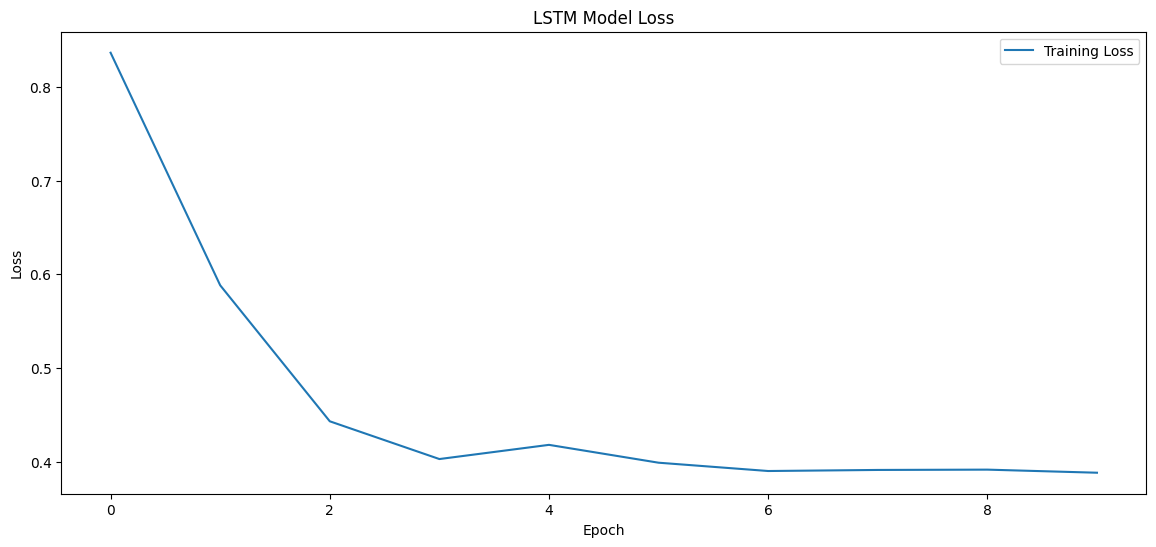

In [147]:
# Instanciando e treinando o modelo
lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), 64)
lstm.fit(X_train, y_train)
plot_lstm_loss(lstm)

In [148]:
pred = lstm.predict(X_test).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


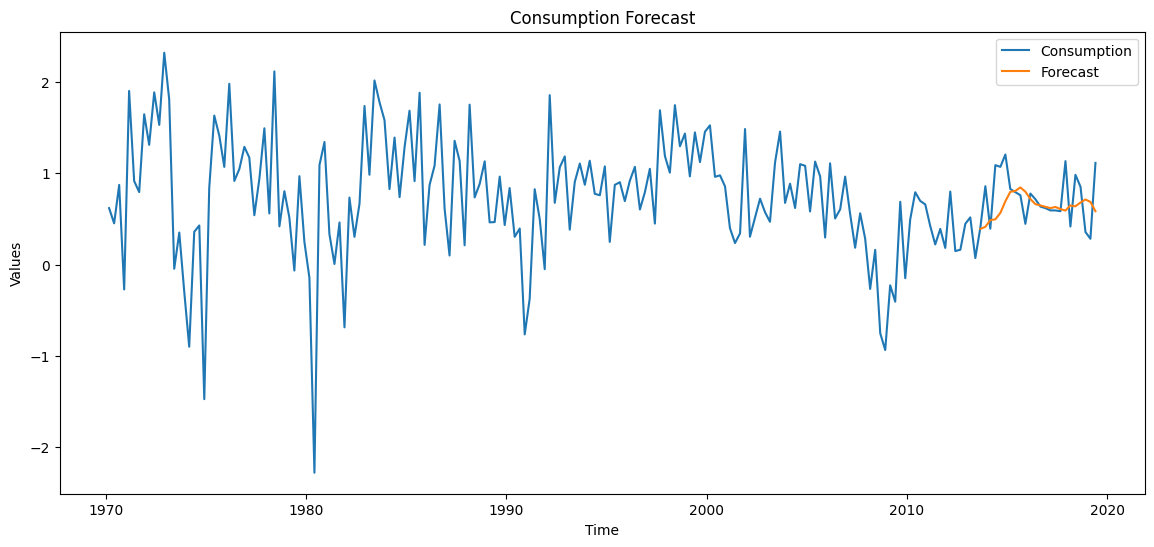

In [149]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(us_change['Quarter'], us_change['Consumption'], label='Consumption')
ax.plot(us_change['Quarter'].iloc[-len(pred):], pred, label='Forecast')
ax.set_title('Consumption Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


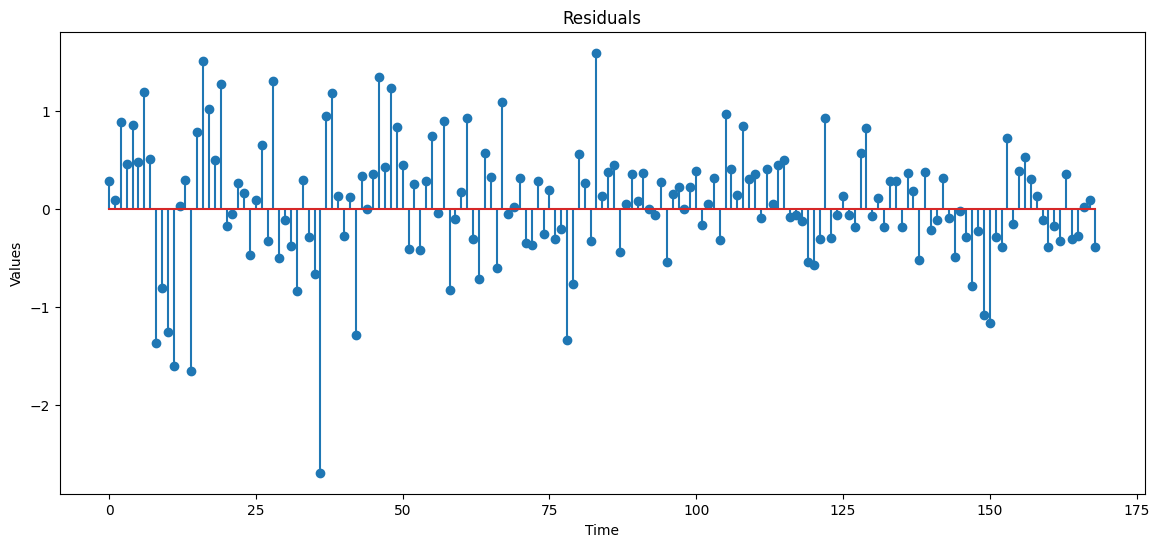

In [150]:
resid = y_train - lstm.predict(X_train).reshape(-1)
plot_resid(resid)

In [151]:
get_metrics(y_test, pred, y_train, lstm.model.count_params())

{'MAE': 0.22711191191271918,
 'MSE': 0.09501954772477754,
 'RMSE': 0.30825240911431256,
 'MAPE': 33.408959837181776,
 'SMAPE': 32.3280082013869,
 'R2': -0.33457925958330526,
 'MASE': 0.39340433161460353,
 'AIC': 33865.51185656741,
 'BIC': 53846.48287309892}

### Busca de hiperparâmetros

Vamos criar um conjunto de validação e tentar encontrar os melhores hiperparâmetros para o modelo:

* Window size
* Units

In [152]:
available_units = [8, 16, 32, 64, 128]
available_epochs = [10, 50, 100]
available_windows = [4, 8, 12, 16]

search_metrics = []

pbar = tqdm(total=len(available_units) * len(available_epochs) * len(available_windows))
for units in available_units:
    for epochs in available_epochs:
        for window in available_windows:
            X, y = create_dataset(us_change.iloc[:-24], window, ['Consumption'], 'Consumption')
            X_train, X_test, y_train, y_test = split_dataset(X, y, 24)

            lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), units)
            lstm.fit(X_train, y_train, epochs=epochs, verbose=0)

            pred = lstm.predict(X_test, verbose=0).reshape(-1)
            temp_metrics = get_metrics(y_test, pred, y_train, lstm.model.count_params())

            search_metrics.append({
                'Units': units,
                'Epochs': epochs,
                'Window': window,
                **temp_metrics
            })
            pbar.update(1)
pbar.close()
search_metrics = pd.DataFrame(search_metrics)

100%|██████████| 60/60 [05:09<00:00,  5.16s/it]


In [153]:
search_metrics.sort_values('RMSE', ascending=True).head(10)

,Units,Epochs,Window,MAE,MSE,RMSE,MAPE,SMAPE,R2,MASE,AIC,BIC
12,16,10,4,0.336665,0.189414,0.435217,91.293364,100.755000,0.087356,0.551896,2298.068261,3675.213189
0,8,10,4,0.341556,0.192517,0.438767,77.173966,103.321524,0.072405,0.559913,618.458245,1006.037956
2,8,10,12,0.357411,0.206594,0.454527,89.486375,103.878431,0.004575,0.583424,620.152055,1007.731766
1,8,10,8,0.362671,0.213385,0.461936,79.399298,110.410186,-0.028144,0.593515,620.928217,1008.507927
36,64,10,4,0.368793,0.219556,0.468568,119.090929,102.334302,-0.057877,0.604564,33885.612440,53866.583456
48,128,10,4,0.384173,0.234933,0.484699,127.099159,103.222203,-0.131970,0.629776,133343.237133,211906.469025
50,128,10,12,0.395623,0.247486,0.497480,129.468608,105.696485,-0.192452,0.645799,133344.486377,211907.718269
51,128,10,16,0.395962,0.251154,0.501152,126.417862,106.661844,-0.210124,0.654794,133344.839437,211908.071329
24,32,10,4,0.405360,0.251724,0.501721,137.166943,105.714328,-0.212872,0.664507,8736.893885,13902.659931
16,16,50,4,0.404150,0.256444,0.506403,146.760185,100.482046,-0.235613,0.662524,2305.339703,3682.484630


In [154]:
best_model = search_metrics.sort_values('RMSE', ascending=True).iloc[0]
best_model

Units       16.000000
Epochs      10.000000
Window       4.000000
MAE          0.336665
MSE          0.189414
RMSE         0.435217
MAPE        91.293364
SMAPE      100.755000
R2           0.087356
MASE         0.551896
AIC       2298.068261
BIC       3675.213189
Name: 12, dtype: float64

Como esperado, o AIC ira sugerir modelos mais simples. Vamos utilizar a ordenação do RMSE para escolher o melhor modelo. Mesmo com AIC um pouco elevado, ainda está dentro de uma margem aceitável.

### Melhor modelo

In [155]:
# Gerando dataset com janela de 5 observações
X, y = create_dataset(us_change, int(best_model.Window), ['Consumption'], 'Consumption')
X_train, X_test, y_train, y_test = split_dataset(X, y, 24)

In [156]:
# Instanciando e treinando o modelo
lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), int(best_model.Units))
lstm.fit(X_train, y_train)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.2070
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8615
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8704 
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8075
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6667 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5747 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5253
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4915
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4529 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4297


In [157]:
pred = lstm.predict(X_test).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


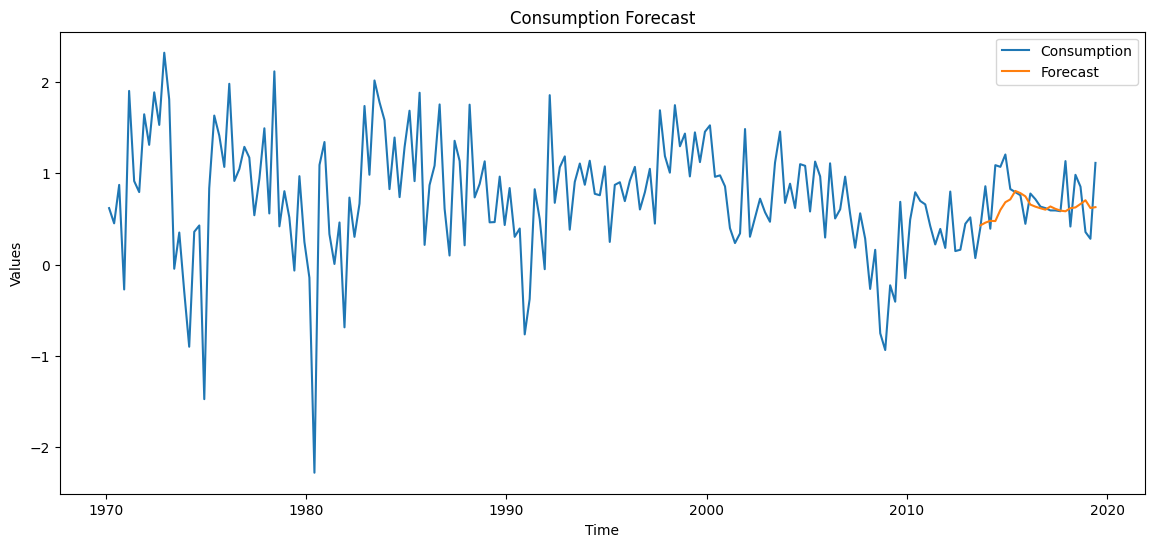

In [158]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(us_change['Quarter'], us_change['Consumption'], label='Consumption')
ax.plot(us_change['Quarter'].iloc[-len(pred):], pred, label='Forecast')
ax.set_title('Consumption Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


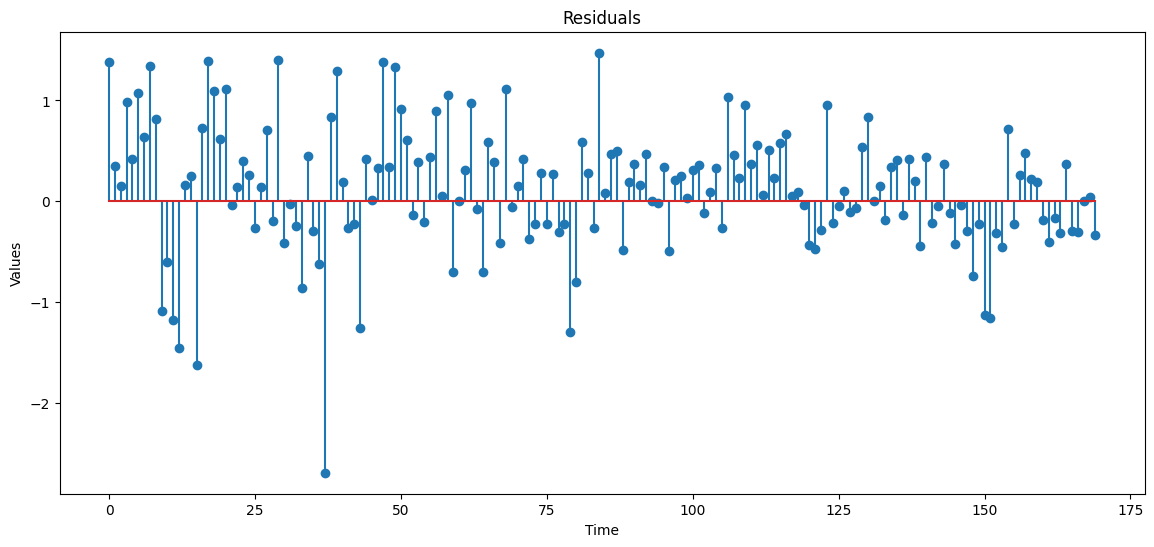

In [159]:
resid = y_train - lstm.predict(X_train).reshape(-1)
plot_resid(resid)

In [160]:
results = get_metrics(y_test, pred, y_train, lstm.model.count_params())
results

{'MAE': 0.22227253074641595,
 'MSE': 0.08912267734430941,
 'RMSE': 0.2985342146962546,
 'MAPE': 31.777287761915368,
 'SMAPE': 31.630698970741477,
 'R2': -0.25175587118938525,
 'MASE': 0.38341354636223285,
 'AIC': 2279.974204930236,
 'BIC': 3657.1191326069843}

## LSTM com covariáveis

### Apresentando o funcionamento

In [161]:
X, y = create_dataset(us_change, int(best_model.Window), ['Income', 'Production', 'Savings', 'Unemployment', 'QuarterDummy', 'Consumption'], 'Consumption')
X_train, X_test, y_train, y_test = split_dataset(X, y, 24)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5530
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5194 
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4490
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4002 
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4194 
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4814 
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3633 
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4351 
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3974 
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3720 


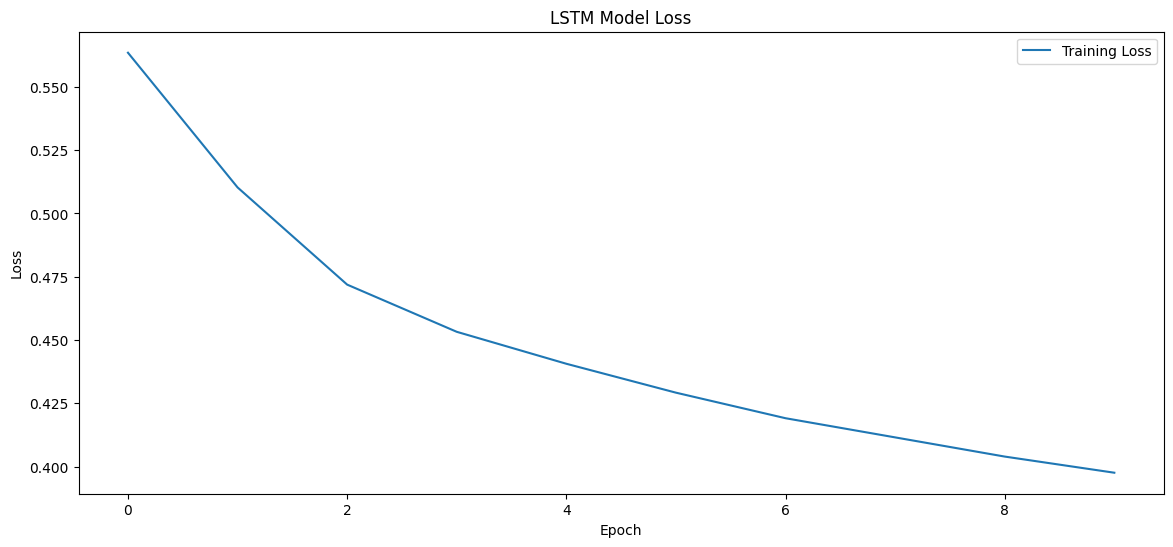

In [162]:
# Instanciando e treinando o modelo
lstm = models.LSTM((X_train.shape[1], X_train.shape[2]), int(best_model.Units))
lstm.fit(X_train, y_train)
plot_lstm_loss(lstm)

In [163]:
pred = lstm.predict(X_test).reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


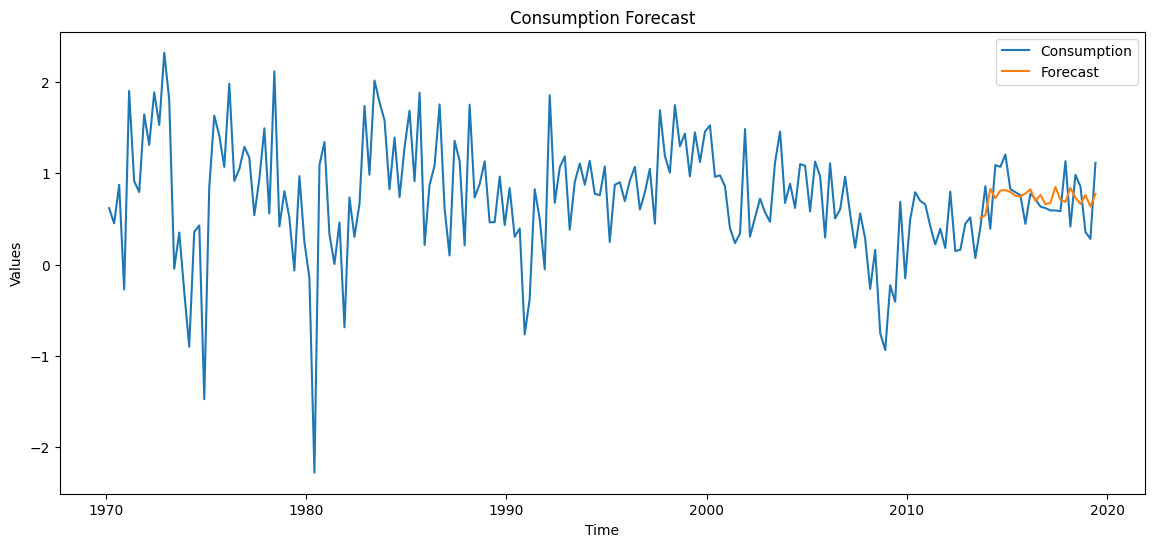

In [164]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(us_change['Quarter'], us_change['Consumption'], label='Consumption')
ax.plot(us_change['Quarter'].iloc[-len(pred):], pred, label='Forecast')
ax.set_title('Consumption Forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


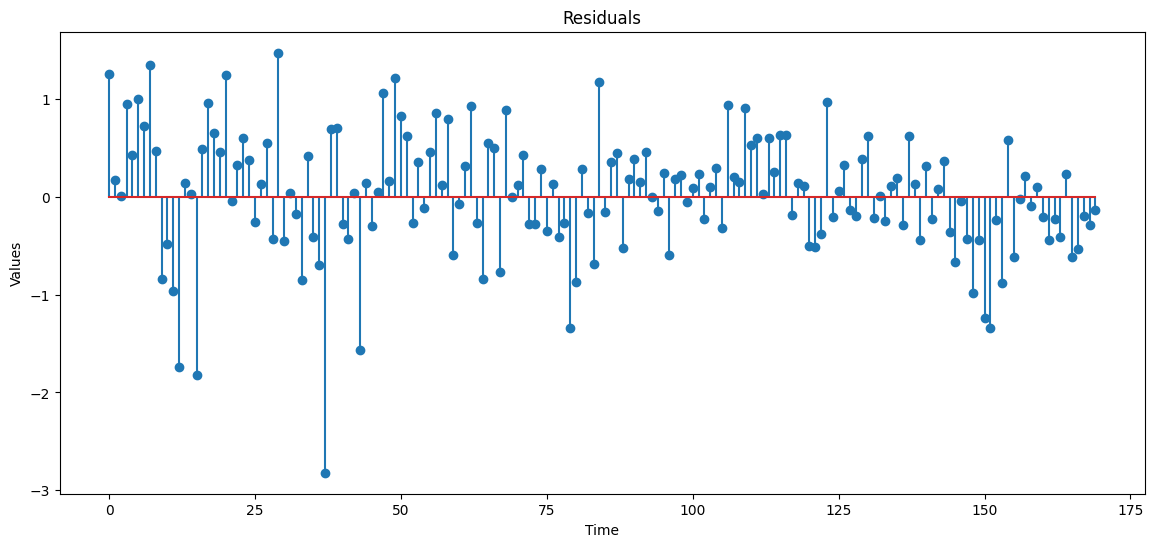

In [165]:
resid = y_train - lstm.predict(X_train).reshape(-1)
plot_resid(resid)

In [166]:
results_cov = get_metrics(y_test, pred, y_train, lstm.model.count_params())
results_cov

{'MAE': 0.2242467671796653,
 'MSE': 0.07302854884297474,
 'RMSE': 0.27023794856195665,
 'MAPE': 38.25431413806743,
 'SMAPE': 31.920162871023894,
 'R2': -0.025708803893685017,
 'MASE': 0.3868190458618235,
 'AIC': 2915.194283978123,
 'BIC': 4669.316437366215}

Nesse caso não iremos buscar pelos melhors hiperparâmentros, vamos utilizar os mesmos hiperparâmetros do modelo anterior.

## Melhor modelo

Após averiguar tanto modelo utilizando apenas a própria série temporal quanto modelo utilizando covariáveis, vamos escolher o melhor modelo e fazer a previsão.

In [167]:
pd.DataFrame([results, results_cov], index=['Univariate', 'Multivariate'])

,MAE,MSE,RMSE,MAPE,SMAPE,R2,MASE,AIC,BIC
Univariate,0.222273,0.089123,0.298534,31.777288,31.630699,-0.251756,0.383414,2279.974205,3657.119133
Multivariate,0.224247,0.073029,0.270238,38.254314,31.920163,-0.025709,0.386819,2915.194284,4669.316437


No nosso caso, o modelo que utiliza covariáveis obteve um melhor desempenho. Apesar de um AIC e BIC maiores que o univariado (devido ao aumento de parâmetros), as outras métricas de avaliação foram melhores.

Por fim, é necessário avaliarmos os resíduos do modelo escolhido para garantir que não há padrões restantes.

In [168]:
ljung_box_results = acorr_ljungbox(resid, lags=range(1, 16), return_df=True)
ljung_box_results

,lb_stat,lb_pvalue
1,3.724386,0.053623
2,7.894795,0.019305
3,20.694130,0.000122
4,20.861103,0.000337
5,20.891957,0.000849
6,21.607495,0.001426
7,21.679809,0.002884
8,24.526485,0.001869
9,24.725745,0.003290
10,25.148198,0.005072


Baseado nos `p-values` dos testes de Ljung-Box podes rejeitar a hipótese nula de que os resíduos são independentes. Isso sugere que ainda há padrões nos resíduos. Dessa forma, o LSTM não foi capaz de capturar toda a informação presente nos dados.

## Conclusão

Após avaliar tanto modelos univariados quanto modelos multivariados, o modelo que utiliza covariáveis obteve um melhor desempenho. Apesar de um AIC e BIC maiores que o univariado (devido ao aumento de parâmetros), as outras métricas de avaliação foram melhores. Contudo, mesmo o melhor modelo obtido não foi capaz de capturar toda a informação presente nos dados, como sugere a análise dos resíduos utilizando o teste de Ljung-Box.